# Elastic Metric for Cell Boundary Analysis

## Notebook setup

In [1]:
import os
import subprocess
import geomstats.backend as gs

geomstats_gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)
os.chdir(geomstats_gitroot_path[:-1])
print("Working directory: ", os.getcwd())

import warnings
warnings.filterwarnings("ignore")

import sys
sys_dir = os.path.dirname(os.getcwd()
                          )
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)

INFO: Using numpy backend


Working directory:  /home/wanxinli/dyn
Directory added to path:  /home/wanxinli


## Standard imports

In [2]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
from scipy import stats

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

from scipy.optimize import linear_sum_assignment as linear_assignment
from sklearn import manifold
from joblib import Parallel, delayed
from numba import jit, njit, prange

## Project-specific imports

In [4]:
import geomstats.datasets.utils as data_utils
from geomstats.geometry.euclidean import Euclidean
from geomstats.geometry.discrete_curves import DiscreteCurves, ClosedDiscreteCurves, L2CurvesMetric

from geomstats.learning.frechet_mean import FrechetMean
from geomstats.learning.kmeans import RiemannianKMeans
from geomstats.learning.pca import TangentPCA


We import the space of curves shapes equipped with different elastic metrics:
- the square root velocity metric (SRV), which is the canonical elastic metrics,
- the generalized elastic metric with parameters a, b.

# Load the dataset of interest

We load an experimental cell dataset with `n_cells` and `n_sampling_points` sampled along the boundary of each cell. 

For faster notebook execution, use small value for `n_cells` and `n_sampling_points`.

In [5]:
dataset_name = "osteosarcoma"  # "osteosarcoma" #  "retinal"
# dataset_name = "retinal"
assert dataset_name in ["osteosarcoma", "retinal"]
cell_type = "dunn"
all_cell_types = ["dunn", "dlm8"]

if dataset_name == "osteosarcoma":
    n_cells = 650
    n_sampling_points = 100
    lines_name = "lines"
    treatments_name = "mutations"

cells, lines, treatments = data_utils.load_cells()
print(f"Total number of cells : {len(cells)}")

TREATMENTS = gs.unique(treatments)
print(TREATMENTS)
LINES = gs.unique(lines)
print(LINES)

SAVEFIG = True
if SAVEFIG:
    figs_dir = os.path.join(os.getcwd(), f"dyn/saved_figs/{dataset_name}")
    print(f"Will save figs to {figs_dir}")
    from datetime import datetime

    now = datetime.now().strftime("%Y%m%d_%H:%M:%S")
    print(now)

Total number of cells : 650
['control' 'cytd' 'jasp']
['dlm8' 'dunn']
Will save figs to /home/wanxinli/dyn/dyn/saved_figs/osteosarcoma
20230514_03:32:39


The variable `quotient` is used to define what is called a `cell_shape`.
- `cells`: has only removed the effect of the translation
- `cell_shapes`: additionally removes what is written in `quotient`: the effect of the scaling, and of the rotation.

Note: in the previous analysis, we were using the linear euclidean metric on cells (without translation), and the srv metric on cell shapes (without translation, scaling and rotation).

This notebook compares the linear versus the srv metric on data on which the same preprocessing has been performed.

In [6]:
ds = {}

n_cells_arr = gs.zeros((3, 2))

for i, treatment in enumerate(TREATMENTS):
    print(f"{treatment} :")
    ds[treatment] = {}
    for j, line in enumerate(LINES):
        to_keep = gs.array(
            [
                one_treatment == treatment and one_line == line
                for one_treatment, one_line in zip(treatments, lines)
            ]
        )
        ds[treatment][line] = [
            cell_i for cell_i, to_keep_i in zip(cells, to_keep) if to_keep_i
        ]
        nb = len(ds[treatment][line])
        print(f"\t {nb} {line}")
        n_cells_arr[i, j] = nb

n_cells_df = pd.DataFrame({"dlm8": n_cells_arr[:, 0], "dunn": n_cells_arr[:, 1]})
n_cells_df = n_cells_df.set_index(TREATMENTS)

display(n_cells_df)
# display(ds)

control :
	 114 dlm8
	 204 dunn
cytd :
	 82 dlm8
	 93 dunn
jasp :
	 62 dlm8
	 95 dunn


,dlm8,dunn
control,114.0,204.0
cytd,82.0,93.0
jasp,62.0,95.0


In [7]:
def interpolate(curve, nb_points):
    """Interpolate a discrete curve with nb_points from a discrete curve.

    Returns
    -------
    interpolation : discrete curve with nb_points points
    """
    old_length = curve.shape[0]
    interpolation = gs.zeros((nb_points, 2))
    incr = old_length / nb_points
    pos = 0
    for i in range(nb_points):
        index = int(gs.floor(pos))
        interpolation[i] = curve[index] + (pos - index) * (
            curve[(index + 1) % old_length] - curve[index]
        )
        pos += incr
    return interpolation


k_sampling_points = 200

In [8]:
cell_rand = cells[gs.random.randint(len(cells))]
cell_interpolation = interpolate(cell_rand, k_sampling_points)

In [9]:
def apply_func_to_ds(input_ds, func):
    """Apply the input function func to the input dictionnary input_ds.

    This function goes through the dictionnary structure and applies
    func to every cell in input_ds[treatment][line].

    It stores the result in a dictionnary output_ds that is returned
    to the user.

    Parameters
    ----------
    input_ds : dict
        Input dictionnary, with keys treatment-line.
    func : callable
        Function to be applied to the values of the dictionnary, i.e.
        the cells.

    Returns
    -------
    output_ds : dict
        Output dictionnary, with the same keys as input_ds.
    """
    output_ds = {}
    for treatment in TREATMENTS:
        output_ds[treatment] = {}
        for line in LINES:
            output_list = []
            for one_cell in input_ds[treatment][line]:
                output_list.append(func(one_cell))
            output_ds[treatment][line] = gs.array(output_list)
    return output_ds

In [10]:
ds_interp = apply_func_to_ds(
    input_ds=ds, func=lambda x: interpolate(x, k_sampling_points)
)

In [11]:
print(ds_interp["control"]["dunn"].shape)

(204, 200, 2)


In [12]:
import numpy as np

def preprocess(curve, tol=1e-10):
    """Preprocess curve to ensure that there are no consecutive duplicate points.

    Returns
    -------
    curve : discrete curve
    """

    dist = curve[1:] - curve[:-1]
    dist_norm = np.sqrt(np.sum(np.square(dist), axis=1))

    if np.any( dist_norm < tol ):
        for i in range(len(curve)-1):
            if np.sqrt(np.sum(np.square(curve[i+1] - curve[i]), axis=0)) < tol:
                curve[i+1] = (curve[i] + curve[i+2]) / 2

    return curve

In [13]:
from geomstats.geometry.pre_shape import PreShapeSpace

M_AMBIENT = 2

PRESHAPE_SPACE = PreShapeSpace(m_ambient=M_AMBIENT, k_landmarks=k_sampling_points)

PRESHAPE_SPACE.equip_with_group_action("rotations")
PRESHAPE_SPACE.equip_with_quotient_structure()


def exhaustive_align(curve, base_curve):
    """Align curve to base_curve to minimize the L² distance.

    Returns
    -------
    aligned_curve : discrete curve
    """
    nb_sampling = len(curve)
    distances = gs.zeros(nb_sampling)
    base_curve = gs.array(base_curve)
    for shift in range(nb_sampling):
        reparametrized = [curve[(i + shift) % nb_sampling] for i in range(nb_sampling)]
        aligned = PRESHAPE_SPACE.fiber_bundle.align(point=gs.array(reparametrized), base_point=base_curve)
        distances[shift] = PRESHAPE_SPACE.embedding_space.metric.norm(
            gs.array(aligned) - gs.array(base_curve)
        )
    shift_min = gs.argmin(distances)
    reparametrized_min = [
        curve[(i + shift_min) % nb_sampling] for i in range(nb_sampling)
    ]
    aligned_curve = PRESHAPE_SPACE.fiber_bundle.align(
        point=gs.array(reparametrized_min), base_point=base_curve
    )
    return aligned_curve

In [14]:
ds_proc = apply_func_to_ds(ds_interp, func=lambda x: preprocess(x))

ds_proj = apply_func_to_ds(ds_proc, func=PRESHAPE_SPACE.projection)
print(ds_proj["control"]["dunn"].shape)

BASE_CURVE = ds_proj["control"]["dunn"][0]
print("Shape of BASE_CURVE:", BASE_CURVE.shape)

ds_align = apply_func_to_ds(ds_proj, func=lambda x: exhaustive_align(x, BASE_CURVE))
print(ds_align["control"]["dunn"].shape)

(204, 200, 2)
Shape of BASE_CURVE: (200, 2)
(204, 200, 2)


In [15]:
cell_shapes_list = []
for treatment in TREATMENTS:
    for line in LINES:
        cell_shapes_list.extend(ds_align[treatment][line])

cell_shapes = gs.array(cell_shapes_list)
print(cell_shapes.shape)

(650, 200, 2)


# Preprocessing

# Remove the cells of the other type


In [20]:
def remove_cells(cells, cell_shapes, lines, treatments, delete_indices):
    """ 
    Remove cells of control group from cells, cell_shapes, lines, treatments,
    the parameters returned from load_treated_osteosarcoma_cells
    Also update n_cells

    :param list[int] delete_indices: the indices to delete
    """
    
    # Delete elements
    cells = np.delete(np.array(cells), delete_indices, axis=0)
    cell_shapes = np.delete(np.array(cell_shapes), delete_indices, axis=0)
    lines = list(np.delete(np.array(lines), delete_indices, axis=0))
    treatments = list(np.delete(np.array(treatments), delete_indices, axis=0))
    global n_cells
    n_cells = cells.shape[0]

    return cells, cell_shapes, lines, treatments

In [21]:
# Find all cells of the other type
remove_indices = []
remove_cell_type = copy.deepcopy(all_cell_types)
remove_cell_type.remove(cell_type)
remove_cell_type = remove_cell_type[0]
for i in range(len(lines)):
    if lines[i] == remove_cell_type:
        remove_indices.append(i)

# Delete all cells of the other type
cells, cell_shapes, lines, treatments = remove_cells(cells, cell_shapes, lines, treatments, remove_indices)

## Remove outliers by DeCOr-MDS using linear metric

In [22]:
""" 
Only remove abnormal cells
"""
if cell_type == "dunn":
    abnormal_outlier_indices = [89]
    cells, cell_shapes, lines, treatments = remove_cells(cells, cell_shapes, lines, treatments, abnormal_outlier_indices)

In [23]:
lines_dict = {lab: i_lab for i_lab, lab in enumerate(np.unique(lines))}
treatments_dict = {lab: i_lab for i_lab, lab in enumerate(np.unique(treatments))}

print(f"Dictionary associated to label \"{lines_name}\":")
print(lines_dict)
print(f"Dictionary associated to label \"{treatments_name}\":")
print(treatments_dict)

Dictionary associated to label "lines":
{'dunn': 0}
Dictionary associated to label "mutations":
{'control': 0, 'cytd': 1, 'jasp': 2}


# Distances to the mean(s)

We compute the distances between:
- every cell in the dataset
- and the mean cell shape, according to the different metrics: Euclidean (Linear), SRV and Elastic Metrics.

In [56]:
R2 = Euclidean(dim=2)
CLOSED_CURVES_SPACE = ClosedDiscreteCurves(R2, k_sampling_points=200)
CURVES_SPACE_SRV = DiscreteCurves(R2, k_sampling_points=200)

SRV_METRIC = CURVES_SPACE_SRV.metric

ELASTIC_METRIC = {}
METRICS = {}
METRICS["Linear"] = L2CurvesMetric
METRICS["SRV"] = SRV_METRIC

In [57]:
means = {}

means["Linear"] = gs.mean(cell_shapes, axis=0)
means["SRV"] = FrechetMean(
        metric=SRV_METRIC, 
        method="default").fit(cell_shapes).estimate_

In [58]:
dists = {}

dists["Linear"] = [gs.linalg.norm(means["Linear"] - cell) / n_sampling_points for cell in cell_shapes]

dists["SRV"] = [
    SRV_METRIC.dist(means["SRV"], cell) / n_sampling_points for cell in cell_shapes
]

In [59]:
dists_summary = pd.DataFrame(
    data={
        lines_name: lines,
        treatments_name: treatments,
        "Linear": dists["Linear"],
        "SRV": dists["SRV"],
    }
)

In [60]:
dists_summary.head()

,lines,mutations,Linear,SRV
0,dunn,control,0.001144,0.004242
1,dunn,control,0.001390,0.004319
2,dunn,control,0.002194,0.005906
3,dunn,control,0.001118,0.003754
4,dunn,control,0.002810,0.007085


# Histograms of distance to the mean

In [61]:
xx = {}

for metric_name in ["Linear", "SRV"]:
    min_dists = gs.array(min(dists_summary[metric_name]))
    max_dists = gs.array(max(dists_summary[metric_name]))
    xx[metric_name] = gs.linspace(gs.floor(min_dists), gs.ceil(max_dists), 100)

In [62]:
def hist_dists_to_means(labels, labels_name):
    """ 
    To the global mean
    """
        
    title_nums = ["(a)", "(b)"]
    color_encoding = {"control": "blue", "cytd": "red", "jasp": "orange"}

    fig, axs = plt.subplots(1, 2, figsize=(20, 8))

    for i, dist_name in enumerate(["Linear", "SRV"]):
        for i_lab, label in enumerate(np.unique(labels)):
            ds = dists_summary[dist_name][dists_summary[labels_name] == label]
            print("ds shape is:", ds.shape)
            (n, bins, patches) = axs[i].hist(
                ds, bins=20, alpha=0.4, density=True, label=label, \
                color = color_encoding[label]
            ) 
            print("n is:", n)
            print("bins is:", bins)
            print("patches is:", patches)
            kde = stats.gaussian_kde(ds)

            # axs[i].plot(xx[dist_name], kde(xx[dist_name]), \
            #             color = color_encoding[label]
            #             )
            axs[i].set_xlim(xmax=0.015)
        if dist_name == "SRV":
            axs[i].set_xlim(xmax=0.015)
        axs[i].legend()
        # axs[i].set_title(f"{title_nums[i]} Distances to {dist_name} mean\n")



ds shape is: (203,)
n is: [310.74923347 704.3649292  952.96431598 725.08154476 393.61569573
 372.89908016 227.88277121 207.16615565 145.01630895  41.43323113
  41.43323113   0.          62.14984669   0.           0.
   0.           0.           0.           0.          20.71661556]
bins is: [0.00098032 0.0012181  0.00145589 0.00169367 0.00193146 0.00216924
 0.00240703 0.00264481 0.0028826  0.00312039 0.00335817 0.00359596
 0.00383374 0.00407153 0.00430931 0.0045471  0.00478488 0.00502267
 0.00526045 0.00549824 0.00573602]
patches is: <BarContainer object of 20 artists>
ds shape is: (93,)
n is: [110.03195884 165.04793826 440.12783536 275.0798971  275.0798971
 330.09587652 275.0798971  550.1597942  385.11185594 220.06391768
 550.1597942  550.1597942  165.04793826 385.11185594 110.03195884
 110.03195884  55.01597942  55.01597942  55.01597942  55.01597942]
bins is: [0.00178586 0.0019813  0.00217675 0.0023722  0.00256764 0.00276309
 0.00295854 0.00315398 0.00334943 0.00354488 0.00374032 0.0

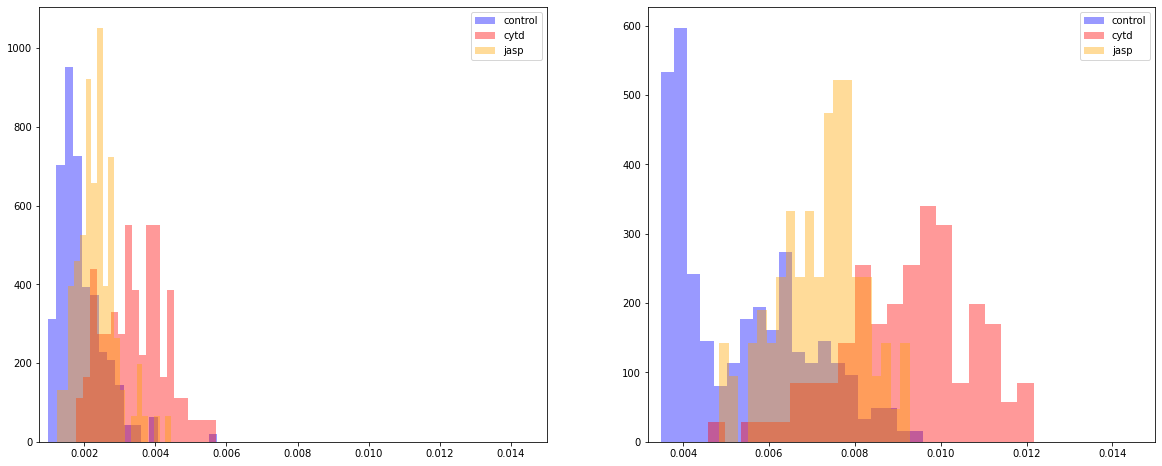

In [63]:
hist_dists_to_means(treatments, treatments_name)
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_{cell_type}_dist_to_means_by_{treatments_name}.pdf"))

In [64]:
mode_1_indices = []
mode_2_indices = []
for index, row in dists_summary.iterrows():
    if row['mutations'] == 'control' and (row['SRV'] > 0.0037 and row['SRV'] < 0.0041):
        mode_1_indices.append(index)
    elif row['mutations'] == 'control' and (row['SRV'] > 0.0062 and row['SRV'] < 0.0066):
        mode_2_indices.append(index)

In [65]:
print(len(mode_1_indices)) 
print(len(mode_2_indices))

55
18


In [66]:
cell_shapes.shape

(391, 200, 2)

(200, 2)


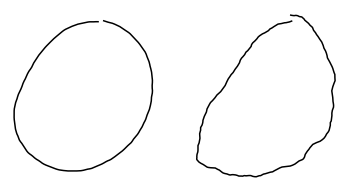

In [77]:
mode_means = {}

mode_means["mode 1"] = FrechetMean(
        metric=SRV_METRIC, 
        method="default").fit(cell_shapes[mode_1_indices]).estimate_
mode_means["mode 2"] = FrechetMean(
        metric=SRV_METRIC, 
        method="default").fit(cell_shapes[mode_2_indices]).estimate_

fig = plt.figure()
print(mode_means["mode 1"].shape)
for i, (mean_name, mean) in enumerate(mode_means.items()):
    ax = fig.add_subplot(1, 2,  i+1)
    # mean = CLOSED_CURVES_SPACE.one_srv_projection(mean)
    mean = CURVES_SPACE_SRV.projection(mean)
    ax.plot(mean[:, 0], mean[:, 1], "black")
    ax.set_aspect("equal")
    ax.axis("off") 
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_{cell_type}_mode_closed_means.svg"))